In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.manifold import TSNE


# Entendendo os fatores que levam a um melhor desempenho na classificação geral (cg)

In [48]:
# Load the dataset
data = pd.read_csv(
    "../data/df_pooled_ranking_clean.csv"
)  # Replace with your dataset path

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nome                  1646 non-null   object 
 1   ano                   1646 non-null   int64  
 2   anos_pm               1646 non-null   float64
 3   bolsista_encoded      1646 non-null   int64  
 4   cg                    1646 non-null   float64
 5   diff_fase             1646 non-null   float64
 6   iaa                   1646 non-null   float64
 7   ian                   1646 non-null   float64
 8   ida                   1646 non-null   float64
 9   idade                 1646 non-null   float64
 10  ieg                   1646 non-null   float64
 11  inde                  1646 non-null   float64
 12  ipp                   1646 non-null   float64
 13  ips                   1646 non-null   float64
 14  ipv                   1646 non-null   float64
 15  na_fase              

In [49]:
data.set_index("nome", inplace=True)

data["ano"] = data["ano"].astype(int)

data["bolsista_encoded"] = data["bolsista_encoded"].astype(int)

data["cg"] = data["cg"].astype(int)

data["ian"] = data["ian"].astype("category")

data["na_fase"] = data["na_fase"].astype(int)

data["ponto_virada_encoded"] = data["ponto_virada_encoded"].astype(int)

data["sexo_encoded"] = data["sexo_encoded"].astype(int)

data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   int64   
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [50]:
data.loc[data["ano"] != 2022, "cg"] = np.nan


## Considerando que não temos o ranking dos anos anteriores, qual a variável definitiva para a sua definição?

In [86]:
df = data.copy()
df = df.dropna(subset=["cg"])
df.head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-2,2022,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.6250,7.500,7.916665,0,0,1
ALUNO-4,2020,2.0,0,451.0,-1.0,8.00002,5.0,0.000000,10.0,4.100000,5.076252,7.1875,6.875,7.750000,0,0,0
ALUNO-4,2022,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.2500,7.500,8.055553,0,0,0
ALUNO-5,2020,1.0,0,415.0,0.0,7.50002,10.0,7.500000,10.0,8.000000,8.077085,8.4375,7.500,8.166665,1,0,0
ALUNO-5,2021,2.0,0,415.0,0.0,7.40000,10.0,5.400000,11.0,7.500000,7.399000,8.5000,7.500,7.400000,1,0,0


In [89]:
# Step 1: Feature Selection using Random Forest
features_for_importance = df.drop(columns=["cg"])
target_for_importance = df["cg"]

# Standardize the features
scaler = StandardScaler()
features_scaled_for_importance = scaler.fit_transform(features_for_importance)

# Train a Random Forest to get feature importance
rf = RandomForestRegressor(random_state=42)
rf.fit(features_scaled_for_importance, target_for_importance)

# Get feature importances and sort them
importances = rf.feature_importances_
feature_names = features_for_importance.columns
sorted_indices = np.argsort(importances)[::-1]

# Print the most important features
print("Feature ranking:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature ranking:
inde: 0.6824316636470823
ano: 0.07668895323203781
ipv: 0.052546721326441954
ida: 0.03372452619822993
ipp: 0.029383099892982253
idade: 0.02923968216186676
ieg: 0.027254620520851872
iaa: 0.021080877425350874
ips: 0.013307472246458712
anos_pm: 0.012677643453445877
sexo_encoded: 0.00640127520465778
diff_fase: 0.005011796911686095
bolsista_encoded: 0.0044571131920105676
na_fase: 0.0027571826512435677
ian: 0.002066252870795117
ponto_virada_encoded: 0.0009711190648586205


A variável que dita a classificação geral é o `inde`. Então vamos definir a classificação para os anos anteriores:

In [53]:
def set_cg(df):
    df = df.sort_values(by="inde", ascending=False)
    df.reset_index(inplace=True)
    df["cg"] = pd.Series(range(1, len(df) + 1))
    df.set_index("nome", inplace=True)

    return df


cg_2021 = set_cg(data[data["ano"] == 2021][["inde", "cg"]])
cg_2022 = set_cg(data[data["ano"] == 2022][["inde", "cg"]])

# fill cg values in the original dataframe with the new cg values for the corresponding year
data.loc[cg_2021.index, "cg"] = cg_2021["cg"]
data.loc[cg_2022.index, "cg"] = cg_2022["cg"]

data.sort_values(by="cg", ascending=True).head()


,ano,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,,
ALUNO-75,2020,1.0,1,1.0,1.0,10.00002,10.0,9.000000,11.0,10.000000,9.687504,9.37500,10.000,9.750010,0,1,1
ALUNO-75,2021,2.0,1,1.0,1.0,10.00000,10.0,8.500000,12.0,9.200000,9.108000,8.80000,7.500,9.700000,0,1,1
ALUNO-75,2022,3.0,1,1.0,2.0,10.00002,10.0,8.500000,13.0,9.660714,9.441522,9.21875,9.375,9.750010,0,1,1
ALUNO-916,2022,5.0,1,2.0,0.0,8.75001,10.0,8.511111,15.0,10.000000,9.354308,9.06250,9.375,9.666675,1,1,1
ALUNO-916,2021,4.0,1,2.0,0.0,8.30000,10.0,7.800000,14.0,9.700000,8.866000,9.20000,7.500,9.300000,1,1,1


Escreve em arquivo o resultado da definição do cg:

In [54]:
data.to_csv("../data/df_pooled_ranking_clean_with_cg.csv")


## Faz sentido realizar a análise considerando a variação do `cg` no tempo?

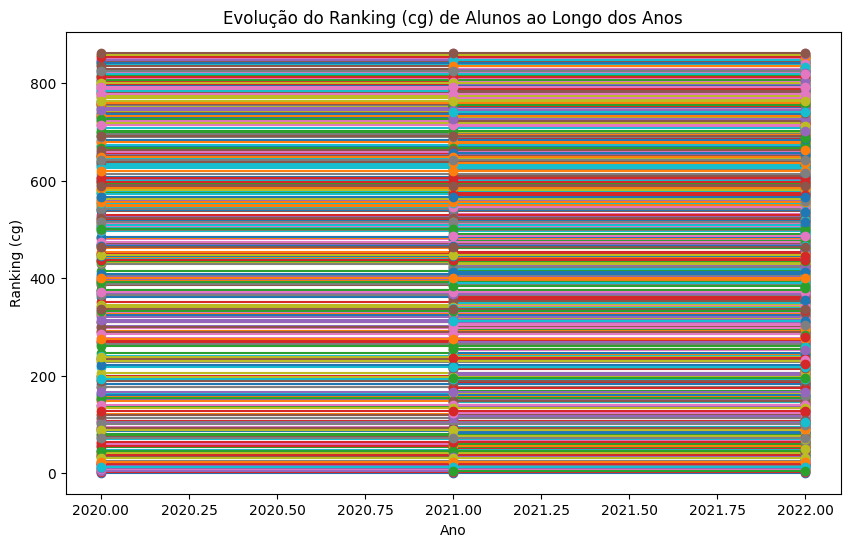

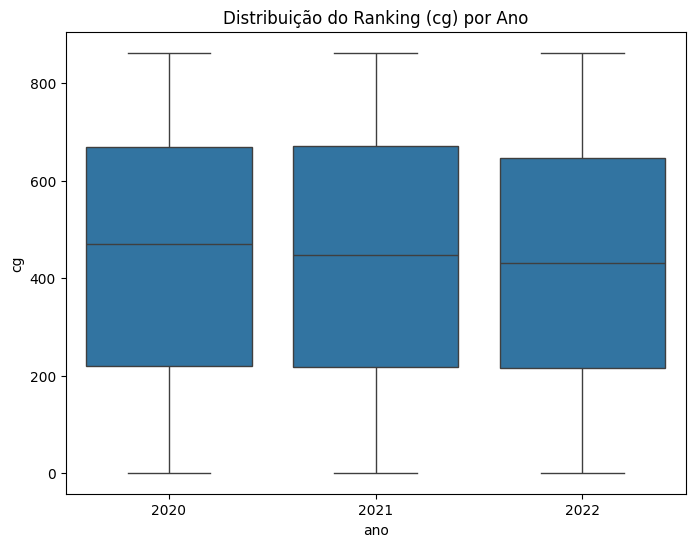

             mean  std
aluno_id              
ALUNO-100   720.0  0.0
ALUNO-1000  592.0  NaN
ALUNO-1001  367.0  0.0
ALUNO-1002  289.0  0.0
ALUNO-1004   88.0  0.0
...           ...  ...
ALUNO-994   340.0  0.0
ALUNO-995   419.0  0.0
ALUNO-996   465.0  0.0
ALUNO-997   151.0  0.0
ALUNO-998   220.0  NaN

[862 rows x 2 columns]
Resultado do teste ANOVA: F_onewayResult(statistic=0.5861200781897649, pvalue=0.5565985213615023)


In [57]:
# Carregar os dados
df = data.copy().reset_index().rename({"nome": "aluno_id"}, axis=1)


# 1. Agrupar os dados por aluno e ano, selecionando as colunas relevantes
# Suponho que exista uma coluna 'aluno_id' que identifica cada aluno e 'ano' para o ano específico
# Adapte o nome da coluna 'aluno_id' caso necessário
df_sorted = df.sort_values(by=["aluno_id", "ano"])

# 2. Calcular a diferença do ranking cg entre os anos para cada aluno
df["cg_diff_2021_2020"] = df.groupby("aluno_id")["cg"].diff(periods=1)
df["cg_diff_2022_2021"] = df.groupby("aluno_id")["cg"].diff(periods=2)

# 3. Visualizar a evolução do ranking de cada aluno ao longo do tempo com um gráfico de linhas
plt.figure(figsize=(10, 6))
for aluno in df["aluno_id"].unique():
    aluno_data = df[df["aluno_id"] == aluno]
    plt.plot(aluno_data["ano"], aluno_data["cg"], marker="o", label=f"Aluno {aluno}")

plt.title("Evolução do Ranking (cg) de Alunos ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Ranking (cg)")
# plt.legend(loc="best", bbox_to_anchor=(1, 0.5))
plt.show()

# 4. Criar boxplots para comparar a distribuição de cg em cada ano
plt.figure(figsize=(8, 6))
sns.boxplot(x="ano", y="cg", data=df, legend=False)
plt.title("Distribuição do Ranking (cg) por Ano")
plt.show()

# 5. Analisar a variação do ranking de cada aluno
df_variation = df.groupby("aluno_id")["cg"].agg(["mean", "std"])
print(df_variation)

# Opcional: realizar um teste ANOVA para verificar se a variação de cg entre os anos é significativa
from scipy.stats import f_oneway

# Criar listas com os valores de cg por ano
cg_2020 = df[df["ano"] == 2020]["cg"]
cg_2021 = df[df["ano"] == 2021]["cg"]
cg_2022 = df[df["ano"] == 2022]["cg"]

# Teste ANOVA para ver se há diferença significativa nos rankings entre os anos
anova_result = f_oneway(cg_2020, cg_2021, cg_2022)
print("Resultado do teste ANOVA:", anova_result)


### Resultado da ANOVA quanto à variação temporal da classificação no tempo:

O p-value de 0.556 é maior que o nível de significância usual de 0.05 (ou 5%). Isso significa que não há evidências suficientes para rejeitar a hipótese nula.

Hipótese nula (H₀): O ranking (cg) dos alunos não varia significativamente entre os anos.
Hipótese alternativa (H₁): O ranking (cg) dos alunos varia significativamente entre os anos.
Dado que o p-value é alto, não podemos concluir que existe uma diferença significativa entre os rankings nos diferentes anos. Em outras palavras, o teste ANOVA sugere que a variação dos rankings entre os anos de 2020, 2021 e 2022 não é estatisticamente significativa.

Logo, uma abordagem razoável é utilizar a média dos indicadores e nos outros casos somente os dados de 2022.

In [60]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, ALUNO-2 to ALUNO-1349
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ano                   1646 non-null   int64   
 1   anos_pm               1646 non-null   float64 
 2   bolsista_encoded      1646 non-null   int64   
 3   cg                    1646 non-null   float64 
 4   diff_fase             1646 non-null   float64 
 5   iaa                   1646 non-null   float64 
 6   ian                   1646 non-null   category
 7   ida                   1646 non-null   float64 
 8   idade                 1646 non-null   float64 
 9   ieg                   1646 non-null   float64 
 10  inde                  1646 non-null   float64 
 11  ipp                   1646 non-null   float64 
 12  ips                   1646 non-null   float64 
 13  ipv                   1646 non-null   float64 
 14  na_fase               1646 non-null   int64   
 1

In [112]:
df = data.reset_index().copy()
df = df[df["ano"] == 2022]
df = df.drop(columns=["ano"], axis=1)
df.set_index("nome", inplace=True)
df.head()


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded
nome,,,,,,,,,,,,,,,,
ALUNO-2,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1
ALUNO-4,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0
ALUNO-5,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0
ALUNO-6,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1
ALUNO-7,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0


# Clusterização

## Feature selection

In [113]:
# Step 1: Feature Selection using Random Forest
features_for_importance = df.drop(columns=["cg", "inde"])
target_for_importance = df["cg"]

# Standardize the features
scaler = StandardScaler()
features_scaled_for_importance = scaler.fit_transform(features_for_importance)

# Train a Random Forest to get feature importance
rf = RandomForestRegressor(random_state=42)
rf.fit(features_scaled_for_importance, target_for_importance)

# Get feature importances and sort them
importances = rf.feature_importances_
feature_names = features_for_importance.columns
sorted_indices = np.argsort(importances)[::-1]

# Print the most important features
print("Feature ranking:")
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


Feature ranking:
ida: 0.5850414271099217
ieg: 0.1960946455715093
ipv: 0.09524338519793354
diff_fase: 0.03557007884165194
ian: 0.034997061306124747
iaa: 0.018381439925691714
ips: 0.011698007445291949
na_fase: 0.008188543588336409
ipp: 0.007814523333650384
idade: 0.0028226926459736707
anos_pm: 0.0020726734704083908
sexo_encoded: 0.000914079375808988
ponto_virada_encoded: 0.0008475254740258882
bolsista_encoded: 0.00031391671367139284


In [130]:
# from sklearn.mixture import GaussianMixture
# from sklearn.model_selection import GridSearchCV
cols_to_cluster = [
    "anos_pm",
    "bolsista_encoded",
    "cg",
    "diff_fase",
    "iaa",
    "ian",
    "ida",
    "idade",
    "ieg",
    "ipp",
    "ips",
    "ipv",
]

# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols_to_cluster])


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 8),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, cv=5
)
grid_search.fit(X_scaled)


GridSearchCV(cv=5, estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 8)},
             scoring=<function gmm_bic_score at 0x7f1203fe5bc0>)

In [131]:
df_res = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_res["mean_test_score"] = -df_res["mean_test_score"]
df_res = df_res.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_res.sort_values(by="BIC score").head()


,Number of components,Type of covariance,BIC score
17,4,diag,1077.533352
18,5,diag,1218.101083
20,7,diag,1300.693326
25,5,full,2529.493266
13,7,tied,2811.000570


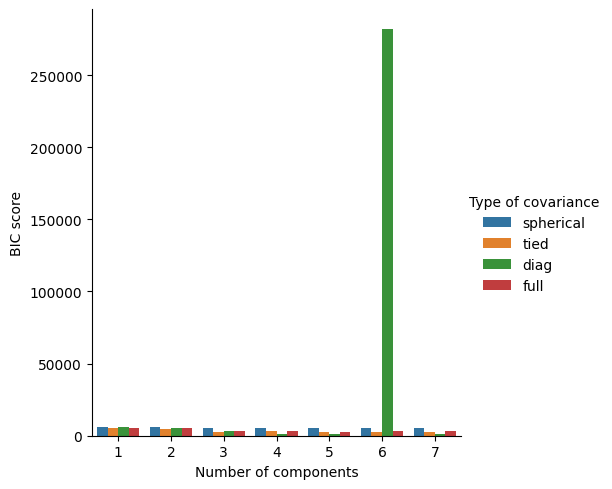

In [132]:
import seaborn as sns

sns.catplot(
    data=df_res,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()


In [133]:
# Apply Gaussian Mixture Model (GMM) for time-based trajectories
gmm = grid_search.best_estimator_
clusters = gmm.fit_predict(X_scaled)

df["cluster"] = clusters

df.head()


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ian,ida,idade,ieg,inde,ipp,ips,ipv,na_fase,ponto_virada_encoded,sexo_encoded,cluster
nome,,,,,,,,,,,,,,,,,
ALUNO-2,0.0,0,245.0,-2.0,10.00002,5.0,8.816667,11.0,7.581705,7.675509,5.625000,7.5,7.916665,0,0,1,0
ALUNO-4,0.0,0,451.0,-1.0,10.00002,5.0,5.083333,12.0,8.071429,7.117065,6.250000,7.5,8.055553,0,0,0,0
ALUNO-5,3.0,0,415.0,-1.0,6.41668,5.0,7.083333,12.0,8.557505,7.232336,6.458333,7.5,7.833337,0,0,0,0
ALUNO-6,0.0,0,221.0,0.0,9.00002,10.0,5.500000,11.0,9.333333,7.741669,6.250000,7.5,7.500000,1,0,1,1
ALUNO-7,0.0,0,357.0,-1.0,10.00002,5.0,5.583333,11.0,9.314954,7.406743,5.937500,7.5,7.916670,0,0,0,0


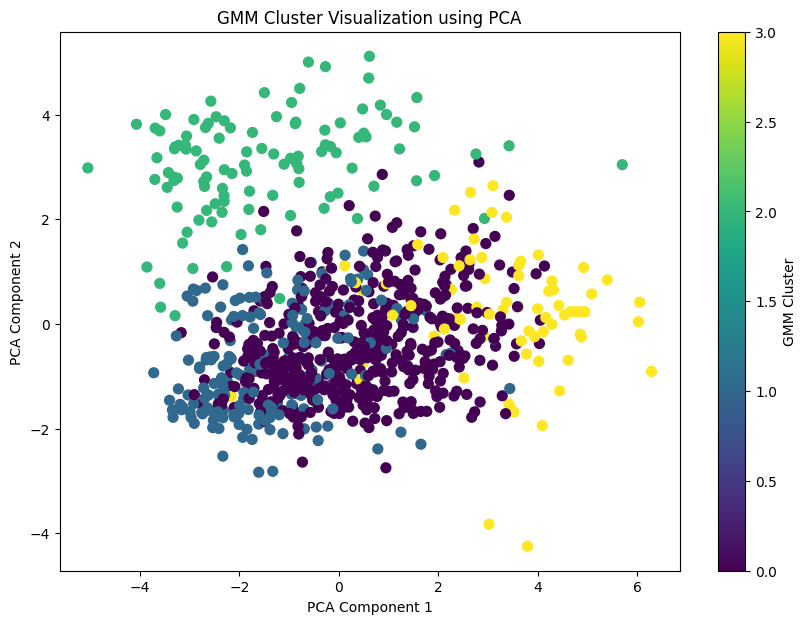

In [134]:
# Step 4: Visualize the GMM clusters using PCA for dimensionality reduction
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=df["cluster"],
    cmap="viridis",
    s=50,
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("GMM Cluster Visualization using PCA")
plt.colorbar(label="GMM Cluster")
plt.show()


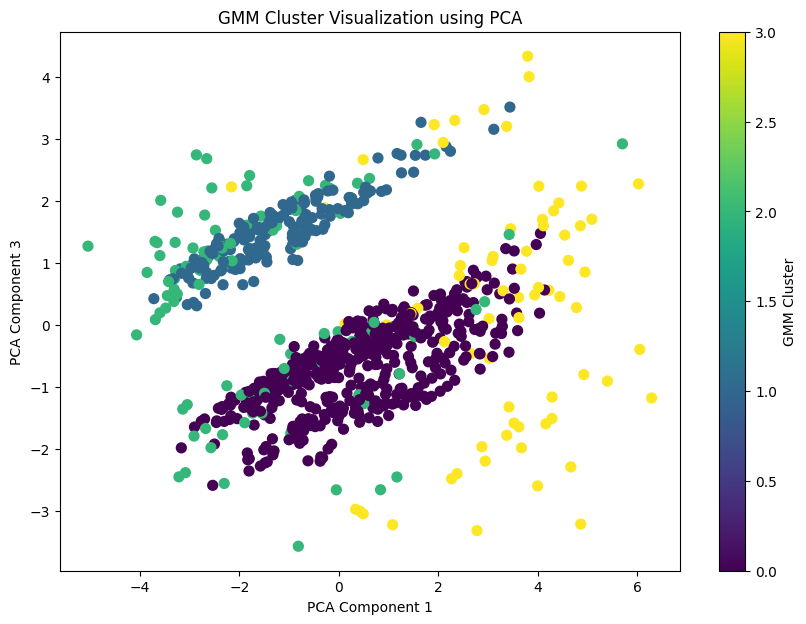

In [135]:
# Step 4: Visualize the GMM clusters using PCA for dimensionality reduction
plt.figure(figsize=(10, 7))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 2],
    c=df["cluster"],
    cmap="viridis",
    s=50,
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 3")
plt.title("GMM Cluster Visualization using PCA")
plt.colorbar(label="GMM Cluster")
plt.show()


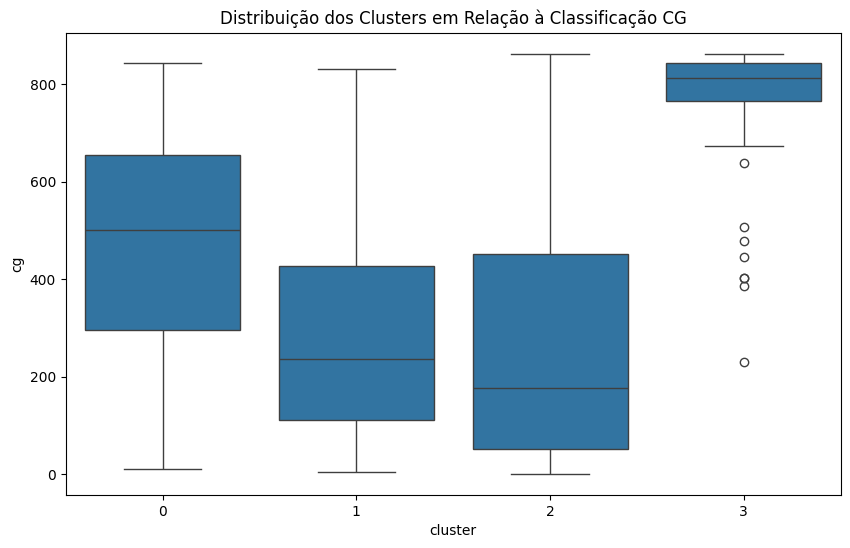

    anos_pm  bolsista_encoded        cg  diff_fase       iaa       ian  \
0 -0.133963         -0.378465  0.175333  -0.411258  0.209226 -0.595497   
1 -0.451229         -0.378465 -0.588629   1.117318  0.265335  1.499681   
2  1.392166          2.642249 -0.689502   0.579834 -0.123928  0.549091   
3  0.005128         -0.378465  1.345514  -0.948483 -1.908720 -0.641257   

        ida     idade       ieg       ipp       ips       ipv  
0 -0.006441  0.020694  0.045208 -0.163682  0.052596  0.022708  
1  0.168711 -0.728485  0.193484 -0.095911  0.176813  0.034848  
2  0.511237  0.651040  0.398494  1.112786 -0.419375  0.650897  
3 -1.144255  0.767639 -1.389659 -0.293281 -0.188975 -1.203719  


In [138]:
# Visualizando a distribuição dos clusters e como eles se relacionam com 'cg'
plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster", y="cg", data=df)
plt.title("Distribuição dos Clusters em Relação à Classificação CG")
plt.show()

# Exibindo as características principais dos clusters
cluster_means = pd.DataFrame(gmm.means_, columns=cols_to_cluster)
print(cluster_means)


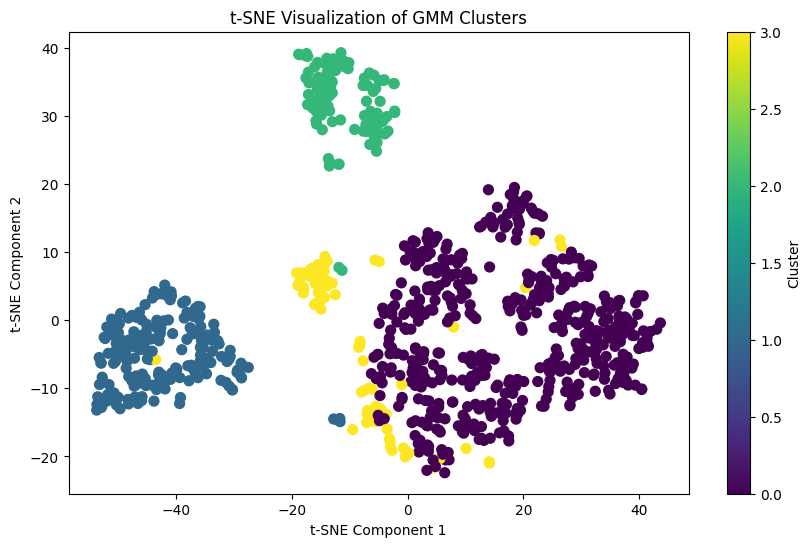

In [139]:
# Adding the cluster information to the original dataframe

# Applying t-SNE to reduce the data to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plotting the t-SNE results
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap="viridis", s=50)
plt.title("t-SNE Visualization of GMM Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [143]:
cols_to_cluster


['anos_pm',
 'bolsista_encoded',
 'cg',
 'diff_fase',
 'iaa',
 'ian',
 'ida',
 'idade',
 'ieg',
 'ipp',
 'ips',
 'ipv',
 'cluster']

In [149]:
df[cols_to_cluster].dtypes


anos_pm              float64
bolsista_encoded       int64
cg                   float64
diff_fase            float64
iaa                  float64
ian                 category
ida                  float64
idade                float64
ieg                  float64
ipp                  float64
ips                  float64
ipv                  float64
cluster                int64
dtype: object

In [162]:
df[cols_to_cluster].describe()


,anos_pm,bolsista_encoded,cg,diff_fase,iaa,ida,idade,ieg,ipp,ips,ipv,cluster
count,862.000000,862.00000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000
mean,1.503480,0.12529,431.500000,-0.943155,8.263065,6.070688,12.329466,7.880728,6.299364,6.901102,7.247953,0.719258
std,1.787649,0.33124,248.982262,0.844614,2.080264,2.059346,2.667051,1.649023,1.135510,1.070202,1.098548,0.977125
min,0.000000,0.00000,1.000000,-5.000000,0.000000,0.000000,8.000000,0.000000,0.000000,2.500000,2.500010,0.000000
25%,0.000000,0.00000,216.250000,-1.000000,7.916672,4.750000,11.000000,6.999971,5.625000,6.250000,6.722220,0.000000
50%,1.000000,0.00000,431.500000,-1.000000,8.750010,6.333333,12.000000,8.312179,6.250000,7.500000,7.333335,0.000000
75%,3.000000,0.00000,646.750000,0.000000,9.500020,7.583333,14.000000,9.102970,7.031250,7.500000,7.916665,1.000000
max,6.000000,1.00000,862.000000,2.000000,10.000020,9.916667,20.000000,10.000000,9.218750,10.000000,10.000010,3.000000


In [158]:
X = df[cols_to_cluster].copy()
X = df.select_dtypes(exclude="category")
X.drop(
    columns=["bolsista_encoded", "na_fase", "ponto_virada_encoded", "sexo_encoded"],
    inplace=True,
)

# Grouping the data by the clusters and calculating the mean for each feature
cluster_means = X.groupby("cluster").mean()

cluster_means


,anos_pm,cg,diff_fase,iaa,ida,idade,ieg,inde,ipp,ips,ipv
cluster,,,,,,,,,,,
0,1.273279,475.765182,-1.289474,8.700421,6.050416,12.394737,7.945138,6.930476,6.114415,6.955972,7.271422
1,0.696809,286.191489,0.000000,8.814289,6.408895,10.393617,8.188442,7.584541,6.188774,7.091090,7.278293
2,3.990741,259.925926,-0.453704,8.005411,7.122891,14.064815,8.537472,7.699753,7.562211,6.452546,7.962579
3,1.458333,764.569444,-1.763889,4.209495,3.748380,14.333333,5.650207,5.240351,5.962818,6.701389,5.935762


In [171]:
cols = X.columns
cols = cols.drop("cg")
cols = cols.drop("cluster")
cols = cols.drop("inde")

print(cols)


Index(['anos_pm', 'diff_fase', 'iaa', 'ida', 'idade', 'ieg', 'ipp', 'ips',
       'ipv'],
      dtype='object')


In [172]:
# Importing stats to handle ANOVA
from scipy import stats

# Rerunning the ANOVA step
anova_results = {}

for column in cols:
    f_value, p_value = stats.f_oneway(
        df[df["cluster"] == 0][column],
        df[df["cluster"] == 1][column],
        df[df["cluster"] == 2][column],
        df[df["cluster"] == 3][column],
    )
    anova_results[column] = p_value

# Converting the results into a DataFrame for easier visualization
anova_df = pd.DataFrame(list(anova_results.items()), columns=["Feature", "P-Value"])

# Sorting by P-Value to highlight the most significant differences
anova_df_sorted = anova_df.sort_values(by="P-Value")


In [173]:
print(anova_df_sorted)


     Feature        P-Value
1  diff_fase  6.727999e-125
2        iaa   9.131689e-83
0    anos_pm   3.078252e-65
4      idade   5.925720e-45
5        ieg   5.181773e-37
6        ipp   1.185680e-36
8        ipv   4.367650e-35
3        ida   5.737233e-29
7        ips   2.125578e-06


I have displayed the results of the ANOVA analysis, which highlight the features that show statistically significant differences between the clusters. The features with the smallest p-values (near 0) are the ones that vary most significantly across the clusters, indicating they might be key differentiators between different groups of students.

In [4]:
df.drop(
    columns=[
        "corraca",
        "cf",
        "ct",
        "pedra",
        "sexo",
        "fase",
        "ponto_virada",
        "pedra_encoded",
    ],
    inplace=True,
)


In [6]:
# feature_names[sorted_indices].to_list()[:12]


In [7]:
# Select the top 10 most important features
# features_scaled_for_importance = features_scaled_for_importance[:, sorted_indices[:11]]


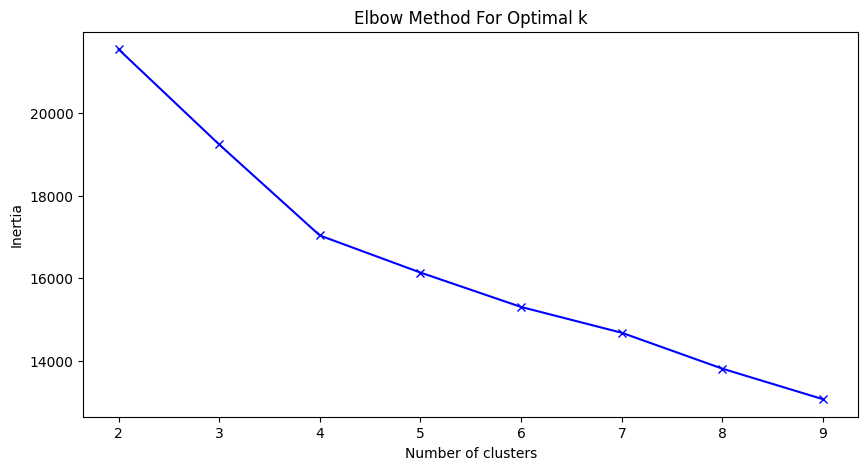

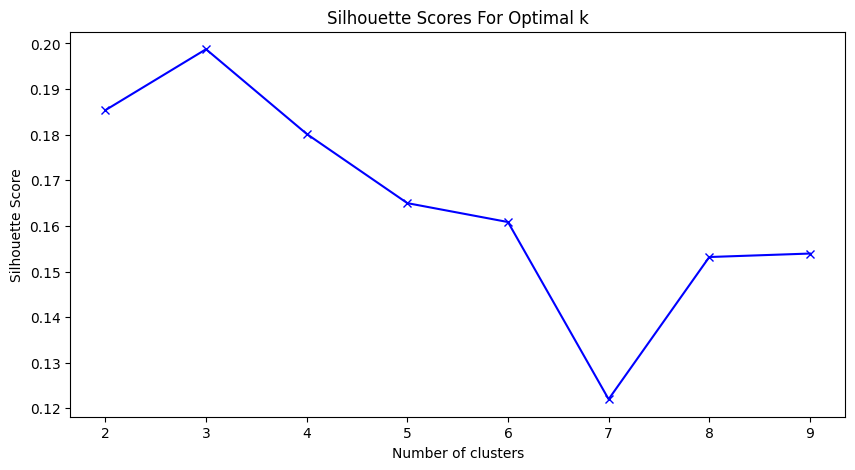

In [8]:
# Step 2: Optimal Number of Clusters using Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(2, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_for_importance)
    inertia.append(
        kmeans.inertia_
    )  # Sum of squared distances to the nearest cluster center
    silhouette_avg = silhouette_score(features_scaled_for_importance, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, silhouette_scores, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores For Optimal k")
plt.show()


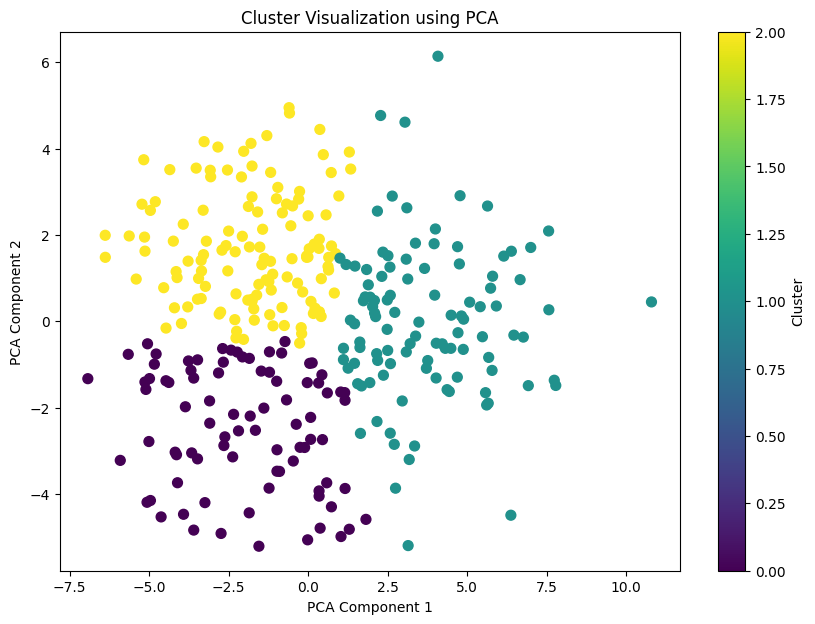

In [9]:
# Step 3: Time-Based Clustering and Predictive Modeling
# Select the most important features based on Random Forest importance

# We will pivot the data to create a time series for each student based on their performance over the three years
# pivot_df = df.pivot(
#     index="nome", columns="ano", values=["iaa", "ieg", "inde", "ipv", "ipp", "cg"]
# )
pivot_df = df.pivot(
    index="nome",
    columns="ano",
    values=[
        "inde",
        "ano",
        "ipv",
        "ida",
        "ipp",
        "idade",
        "ieg",
        "iaa",
        "ips",
        "anos_pm",
        "cg",
    ],
)

pivot_df.columns = ["_".join(map(str, col)).strip() for col in pivot_df.columns.values]
pivot_df = pivot_df.dropna()  # Drop rows with missing data

# Standardize the time-based features
pivot_df_scaled = scaler.fit_transform(pivot_df)

# Apply KMeans clustering for time-based trajectories based on selected optimal number of clusters (use k from the elbow method)
optimal_k = 3  # Based on Elbow/Silhouette methods
kmeans_time_based = KMeans(n_clusters=optimal_k, random_state=42)
pivot_df["cluster"] = kmeans_time_based.fit_predict(pivot_df_scaled)

# Step 4: Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(pivot_df_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(
    principal_components[:, 0],
    principal_components[:, 1],
    c=pivot_df["cluster"],
    cmap="viridis",
    s=50,
)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization using PCA")
plt.colorbar(label="Cluster")
plt.show()
